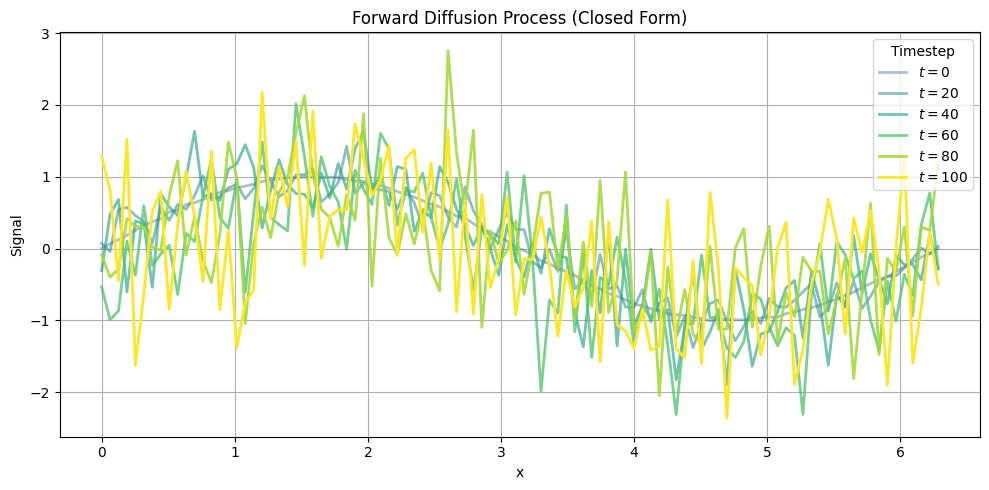

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# --- Config ---
n_steps = 101
n_points = 100
beta_start = 0.0001
beta_end = 0.02
x = torch.linspace(0, 2 * torch.pi, n_points)
x0 = torch.sin(x).unsqueeze(0)  # shape: [1, n_points]

# --- Create beta schedule and compute cumulative alpha_bar ---
beta_t = torch.linspace(beta_start, beta_end, n_steps)
alpha_t = 1.0 - beta_t
alpha_bar = torch.cumprod(alpha_t, dim=0)

# --- Generate trajectory using closed-form forward process ---
trajectory = []
for t in range(n_steps):
    noise = torch.randn_like(x0)
    xt = torch.sqrt(alpha_bar[t]) * x0 + torch.sqrt(1 - alpha_bar[t]) * noise
    trajectory.append(xt.squeeze().numpy())

# --- Plot every 20th step with color fading and stronger visibility for later steps ---
plt.figure(figsize=(10, 5))
plot_steps = list(range(0, n_steps, 20))
cmap = plt.cm.viridis
colors = cmap(np.linspace(0.3, 1.0, len(plot_steps)))

for i, t in enumerate(plot_steps):
    alpha = 0.4 + 0.6 * (i / (len(plot_steps) - 1))  # alpha: 0.4 → 1.0
    plt.plot(x.numpy(), trajectory[t], color=colors[i], alpha=alpha, linewidth=2, label=f"$t={t}$")

plt.title("Forward Diffusion Process (Closed Form)")
plt.xlabel("x")
plt.ylabel("Signal")
plt.grid(True)
plt.legend(title="Timestep", loc="upper right")
plt.tight_layout()
plt.savefig("diffusion1.png", dpi=150)
plt.show()


## Now Training the denoising, minimal version

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# --- Config ---
n_points = 100
n_steps = 50
noise_std = 0.2
class_idx = 2  # Select sine class 0 to 4

# --- Generate sine waves ---
x = torch.linspace(0, 2 * torch.pi, n_points)
phases = torch.arange(5) * (2 * torch.pi / 5)
sine_set = torch.stack([torch.sin(x + p) for p in phases])
x_target = sine_set[class_idx].unsqueeze(0)  # shape [1, n_points]
label = torch.nn.functional.one_hot(torch.tensor([class_idx]), num_classes=5).float()

# --- Model ---
class DenoiseMLP(nn.Module):
    def __init__(self, n_points, n_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_points + n_classes, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, n_points)
        )
    def forward(self, x, label):
        return self.net(torch.cat([x, label], dim=1))

model = DenoiseMLP(n_points, n_classes=5)


In [3]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

# Add progressive noise
def add_noise_sequence(x0, n_steps, noise_std):
    x = x0.clone()
    trajectory = [x]
    for _ in range(n_steps):
        x = x + (noise_std / n_steps) * torch.randn_like(x)
        trajectory.append(x)
    return trajectory

for epoch in range(1000):
    noisy_traj = add_noise_sequence(x_target, n_steps, noise_std)
    loss = 0.0
    for t in reversed(range(1, len(noisy_traj))):
        x_in = noisy_traj[t]
        x_out = noisy_traj[t-1]
        x_pred = model(x_in, label)
        loss += loss_fn(x_pred, x_out)
    loss /= n_steps
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.6f}")


Epoch 0: Loss = 0.507524
Epoch 100: Loss = 0.000463
Epoch 200: Loss = 0.000448
Epoch 300: Loss = 0.000561
Epoch 400: Loss = 0.000508
Epoch 500: Loss = 0.000493
Epoch 600: Loss = 0.000532
Epoch 700: Loss = 0.000511
Epoch 800: Loss = 0.000516
Epoch 900: Loss = 0.000545


## Get the inverse trajectory

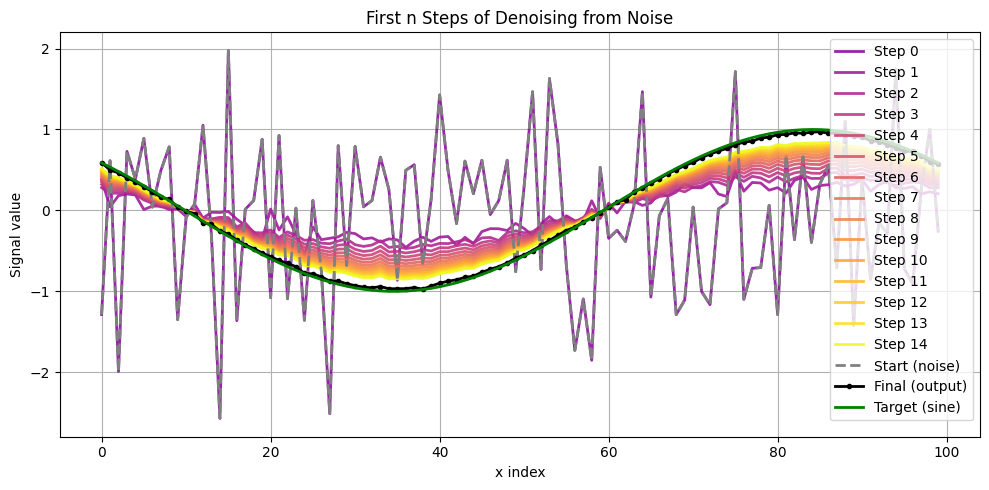

In [4]:
# --- Reverse from noise ---
with torch.no_grad():
    x = torch.randn_like(x_target)
    x_start = x.clone()
    traj = [x.squeeze().numpy()]
    for _ in range(n_steps):
        x = model(x, label)
        traj.append(x.squeeze().numpy())

# --- Plot first 10 steps + start, final, target ---
import numpy as np
plt.figure(figsize=(10, 5))

steps_to_plot = list(range(0, 15))  # first 10 steps
colors = plt.cm.plasma(np.linspace(0.3, 1.0, len(steps_to_plot)))

for i, t in enumerate(steps_to_plot):
    plt.plot(traj[t], color=colors[i], alpha=0.9, linewidth=2, label=f"Step {t}")

# Add clearly labeled curves
plt.plot(x_start.squeeze().numpy(), 'gray', linestyle='dashed', linewidth=2, label="Start (noise)")
plt.plot(traj[-1], 'k.', linestyle='-', linewidth=2, label="Final (output)")
plt.plot(x_target.squeeze().numpy(), 'g', linestyle='-', linewidth=2, label="Target (sine)")

plt.title("First n Steps of Denoising from Noise")
plt.xlabel("x index")
plt.ylabel("Signal value")
plt.legend(loc="upper right")
plt.grid(True)
plt.tight_layout()
plt.savefig("diffusion_denoising.png")
plt.show()
